# Image Search: Histogram Comparison

In [1]:
# # Donwload and unpack data
# !wget http://download.yandex.ru/imat2011/imat2011_1.zip -P ../.data
# !unzip -q ../.data/imat2011_1.zip -d ../.data/imat2011

In [2]:
# !sudo apt-get install python3-opencv
# !pip install opencv-python
# !pip install seaborn
# !pip install sklearn

In [1]:
import cv2 as cv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering

In [2]:
PATH_PROJECT = Path('/home/team/sasha/data/experimental/image_retrieval/')

In [3]:
# with open(PATH_PROJECT / '.data/imat2011/learning.txt','r', newline='\n') as fin:
with open('learning.txt','r', newline='\n') as fin:
    learning = [line.strip() for line in fin]

In [4]:
learning[:4]

['1_2.jpg', '1_4.jpg', '2_2.jpg', '2_4.jpg']

In [5]:
learning_dict = defaultdict(set)
for l in learning:
    g, i = l.split('.')[0].split('_')
    learning_dict[int(g)].add(int(i))
learning_dict

defaultdict(set,
            {1: {2, 4},
             2: {2, 4},
             3: {3, 5},
             4: {2, 4},
             5: {2, 5},
             6: {1, 4},
             7: {2, 3},
             8: {3, 4},
             9: {1, 2},
             10: {1, 2},
             11: {1},
             12: {2, 4},
             13: {3},
             14: {4, 5},
             15: {2, 5},
             16: {1, 4},
             17: {1, 3},
             18: {2, 3},
             19: {2, 4},
             20: {3, 4},
             21: {2, 3},
             22: {4},
             23: {1, 3},
             24: {2, 3},
             25: {2, 3},
             26: {1, 4},
             27: {2, 5},
             28: {3, 5},
             29: {1},
             30: {2, 4},
             31: {1, 2},
             33: {1, 3},
             35: {1, 2},
             36: {1},
             37: {1, 2},
             38: {3, 4},
             39: {4, 5},
             40: {5},
             42: {2, 5},
             44: {1, 3},
          

## Select image group

In [6]:
image_group = 2

In [7]:
# path_tmpl = str(PATH_PROJECT) + '/.data/imat2011/result_jpg_300/' + '%d_%d.jpg'
path_tmpl = 'result_jpg_300/' + '%d_%d.jpg'

## Calculate distance between histograms -> Exploration

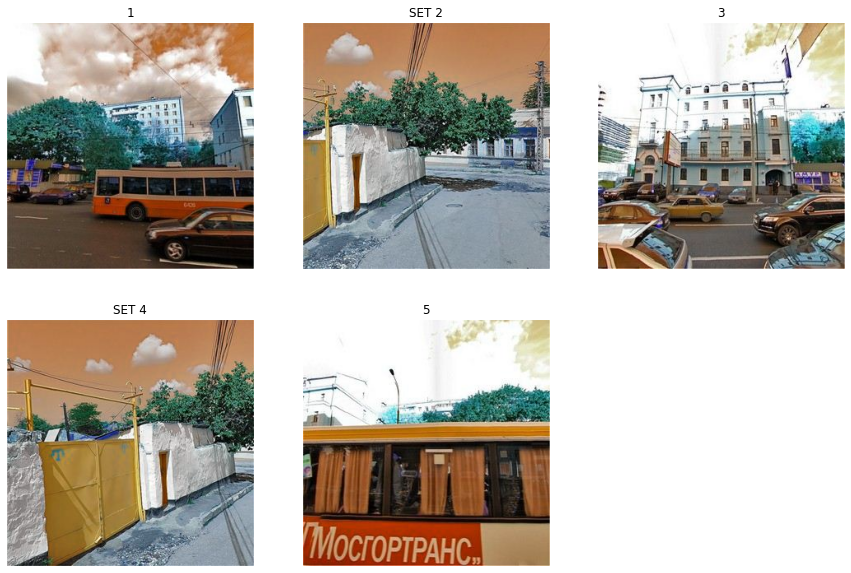

In [8]:
# Load images
paths = [path_tmpl % (image_group, i) for i in range(1,6)]
imgs = [cv.imread(path) for path in paths]

plt.figure(figsize=(15, 10))
for i, img in enumerate(imgs, 1):
    ax = plt.subplot(2, 3, i)
    plt.imshow(img)
    if i in learning_dict[image_group]:
        plt.title("SET %d" % i)
    else:
        plt.title("%d" % i)
    plt.axis("off")

In [9]:
# convert image to YCbCr format 
imgs_hsv = [cv.cvtColor(img, cv.COLOR_BGR2YCR_CB) for img in imgs]
hsv_test1, hsv_test2, hsv_test3, hsv_test4, hsv_test5 = imgs_hsv

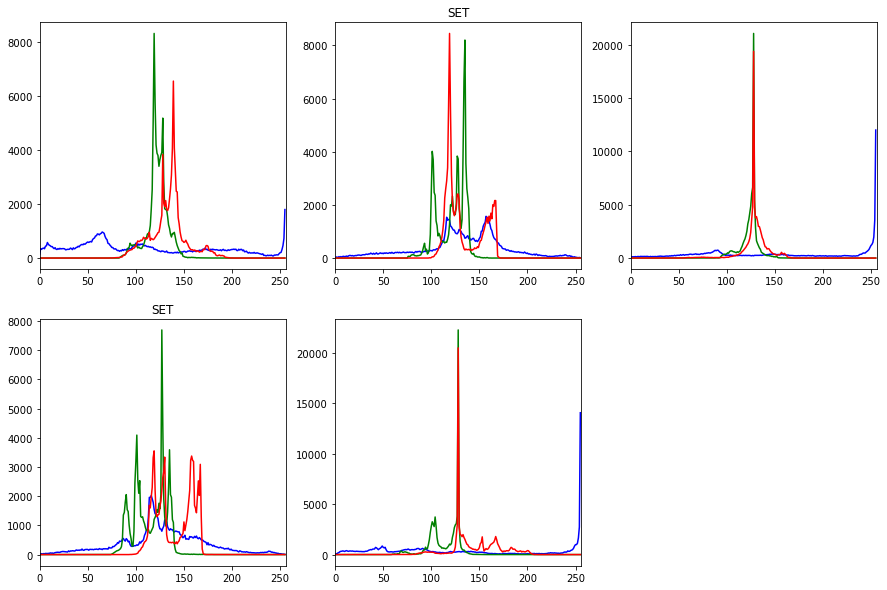

In [10]:
plt.figure(figsize=(15, 10))
for i, img in enumerate(imgs_hsv, 1):
    ax = plt.subplot(2, 3, i)

    color = ('b','g','r')
    for j, col in enumerate(color):
        hist = cv.calcHist([img], [j], None, [256], [0, 256], accumulate=False)
        # cv.normalize(hist, hist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
        plt.plot(hist, color = col)
        plt.xlim([0, 256])
        if i in learning_dict[image_group]:
            plt.title("SET")

In [11]:
# Calculate the histograms
luma_bins = 12
cr_bins = 256
cb_bins = 256
y_bins = 4
histSize = [luma_bins, cr_bins, cb_bins]

luma_ranges = [0, 256]
cr_ranges = [0, 256]
cb_ranges = [0, 256]
y_ranges = [0, 300]
ranges = luma_ranges + cr_ranges + cb_ranges

channels = [0, 1, 2]

hists = []
for img in imgs_hsv:
    hist = cv.calcHist([img], channels, None, histSize, ranges, accumulate=False)
    # cv.normalize(hist, hist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
    hists.append(hist)

## Draw 5x5 matrix

In [12]:
intersections = np.zeros((5,5))
labels = ['Image %d' % i for i in range(1, 6)]
for i, hist1 in enumerate(hists):
    for j, hist2 in enumerate(hists):
        intersections[i,j] = cv.compareHist(hist1, hist2, cv.HISTCMP_INTERSECT)

In [13]:
intersections /= np.max(intersections)

In [17]:
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(intersections,
#             xticklabels = labels,
#             yticklabels = labels, 
#             # vmin=0, vmax=1,
#             cmap ="YlGnBu",
#             annot=True, square=False, cbar=True)
# plt.yticks(rotation=0)
# plt.show()

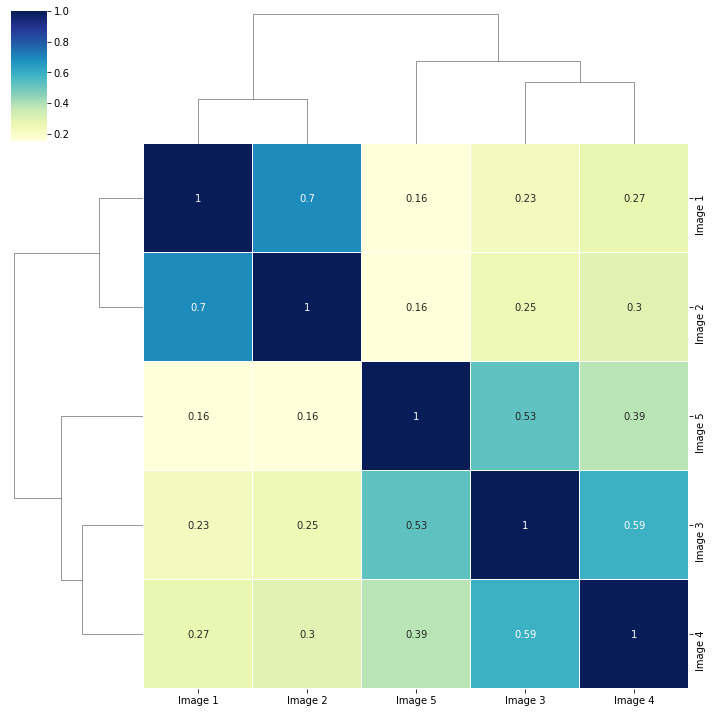

In [15]:
# with clustering
cg = sns.clustermap(
    intersections, 
    xticklabels = labels,
    yticklabels = labels,
    cmap ="YlGnBu", 
    linewidths = 0.1,
    annot=True, square=False, cbar=True
)

## Calculate accuracy

In [26]:
luma_bins = 12
cr_bins = 64
cb_bins = 64
y_bins = 4
histSize = [luma_bins, cr_bins, cb_bins]
luma_ranges = [0, 256]
cr_ranges = [0, 256]
cb_ranges = [0, 256]
y_ranges = [0, 300]
ranges = luma_ranges + cr_ranges + cb_ranges
channels = [0, 1, 2]

    
true_positive_count = 0
for image_group, sets in learning_dict.items():
    
#     path_tmpl = str(PATH_PROJECT) + '/.data/imat2011/result_jpg_300/' + '%d_%d.jpg'
    path_tmpl = 'result_jpg_300/' + '%d_%d.jpg'
    
    paths = [path_tmpl % (image_group, i) for i in range(1,6)]
    imgs = [cv.imread(path) for path in paths]
    imgs_hsv = [cv.cvtColor(img, cv.COLOR_BGR2YCR_CB) for img in imgs]
    
    hists = [cv.calcHist([img], channels, None, histSize, ranges, accumulate=False) for img in imgs_hsv]
        
    intersections = np.zeros((5,5))
    labels = ['Image %d' % i for i in range(1, 6)]
    for i, hist1 in enumerate(hists):
        for j, hist2 in enumerate(hists):
            intersections[i,j] = cv.compareHist(hist1, hist2, cv.HISTCMP_INTERSECT)
    
    intersections /= np.max(intersections)
    
    clustering = AgglomerativeClustering().fit(intersections)
    
    clusters = defaultdict(set)
    for i, c in enumerate(clustering.labels_, 1):
        clusters[c].add(i)
    
    is_match = sum(1 for v in clusters.values() if v == sets)
    true_positive_count += is_match
        
accuracy = true_positive_count / len(learning_dict)
print('Accuracy: ' + str(100 * accuracy) + '%')

Accuracy: 94.13754227733935%


In [19]:
sets

{2, 5}

## Indexing / Retrieval

In [20]:
import heapq
import numpy as np
import os
import cv2 as cv

In [21]:
# # heap usage example
# cs = [1,2,3,4,5,6,7,8,9,10]
# img = 4.5
# k = 5

# closests = [(abs(c-img), c) for c in cs[:k]]
# print(closests)
# heapq._heapify_max(closests)

# for c in cs:
#     d = abs(c-img)
#     if d < closests[0][0]:
#         heapq._heapreplace_max(closests, (d, c))
        
# print(closests)

In [ ]:
%%time
img_dir = 'result_jpg_300/'
# PATH_IMGS = PATH_PROJECT / '.data/imat2011/result_jpg_300/'

index = []
# for path in list(PATH_IMGS.glob('*.jpg')):
for image_path in os.listdir(img_dir):
    path = os.path.join(img_dir, image_path)
    try:
        img = cv.imread(str(path))
        imgs_hsv = cv.cvtColor(img, cv.COLOR_BGR2YCR_CB)
        hist = cv.calcHist([imgs_hsv], channels, None, histSize, ranges, accumulate=False)
        index.append((hist, img))
        print(path)
    except:
        pass

result_jpg_300/1000_1.jpg
result_jpg_300/1000_2.jpg
result_jpg_300/1000_3.jpg
result_jpg_300/1000_4.jpg
result_jpg_300/1000_5.jpg
result_jpg_300/1001_1.jpg
result_jpg_300/1001_2.jpg
result_jpg_300/1001_3.jpg
result_jpg_300/1001_4.jpg
result_jpg_300/1001_5.jpg
result_jpg_300/1002_1.jpg
result_jpg_300/1002_2.jpg
result_jpg_300/1002_3.jpg
result_jpg_300/1002_4.jpg
result_jpg_300/1002_5.jpg
result_jpg_300/1003_1.jpg
result_jpg_300/1003_2.jpg
result_jpg_300/1003_3.jpg
result_jpg_300/1003_4.jpg
result_jpg_300/1003_5.jpg
result_jpg_300/1004_1.jpg
result_jpg_300/1004_2.jpg
result_jpg_300/1004_3.jpg
result_jpg_300/1004_4.jpg
result_jpg_300/1004_5.jpg
result_jpg_300/1005_1.jpg
result_jpg_300/1005_2.jpg
result_jpg_300/1005_3.jpg
result_jpg_300/1005_4.jpg
result_jpg_300/1005_5.jpg
result_jpg_300/1006_1.jpg
result_jpg_300/1006_2.jpg
result_jpg_300/1006_3.jpg
result_jpg_300/1006_4.jpg
result_jpg_300/1006_5.jpg
result_jpg_300/1007_1.jpg
result_jpg_300/1007_2.jpg
result_jpg_300/1007_3.jpg
result_jpg_3

result_jpg_300/1060_1.jpg
result_jpg_300/1060_2.jpg
result_jpg_300/1060_3.jpg
result_jpg_300/1060_4.jpg
result_jpg_300/1060_5.jpg
result_jpg_300/1061_1.jpg
result_jpg_300/1061_2.jpg
result_jpg_300/1061_3.jpg
result_jpg_300/1061_4.jpg
result_jpg_300/1061_5.jpg
result_jpg_300/1062_1.jpg
result_jpg_300/1062_2.jpg
result_jpg_300/1062_3.jpg
result_jpg_300/1062_4.jpg
result_jpg_300/1062_5.jpg
result_jpg_300/1063_1.jpg
result_jpg_300/1063_2.jpg
result_jpg_300/1063_3.jpg
result_jpg_300/1063_4.jpg
result_jpg_300/1063_5.jpg
result_jpg_300/1064_1.jpg
result_jpg_300/1064_2.jpg
result_jpg_300/1064_3.jpg
result_jpg_300/1064_4.jpg
result_jpg_300/1064_5.jpg
result_jpg_300/1065_1.jpg
result_jpg_300/1065_2.jpg
result_jpg_300/1065_3.jpg
result_jpg_300/1065_4.jpg
result_jpg_300/1065_5.jpg
result_jpg_300/1066_1.jpg
result_jpg_300/1066_2.jpg
result_jpg_300/1066_3.jpg
result_jpg_300/1066_4.jpg
result_jpg_300/1066_5.jpg
result_jpg_300/1067_1.jpg
result_jpg_300/1067_2.jpg
result_jpg_300/1067_3.jpg
result_jpg_3

result_jpg_300/1118_1.jpg
result_jpg_300/1118_2.jpg
result_jpg_300/1118_3.jpg
result_jpg_300/1118_4.jpg
result_jpg_300/1118_5.jpg
result_jpg_300/1119_1.jpg
result_jpg_300/1119_2.jpg
result_jpg_300/1119_3.jpg
result_jpg_300/1119_4.jpg
result_jpg_300/1119_5.jpg
result_jpg_300/111_1.jpg
result_jpg_300/111_2.jpg
result_jpg_300/111_3.jpg
result_jpg_300/111_4.jpg
result_jpg_300/111_5.jpg
result_jpg_300/1120_1.jpg
result_jpg_300/1120_2.jpg
result_jpg_300/1120_3.jpg
result_jpg_300/1120_4.jpg
result_jpg_300/1120_5.jpg
result_jpg_300/1121_1.jpg
result_jpg_300/1121_2.jpg
result_jpg_300/1121_3.jpg
result_jpg_300/1121_4.jpg
result_jpg_300/1121_5.jpg
result_jpg_300/1122_1.jpg
result_jpg_300/1122_2.jpg
result_jpg_300/1122_3.jpg
result_jpg_300/1122_4.jpg
result_jpg_300/1122_5.jpg
result_jpg_300/1123_1.jpg
result_jpg_300/1123_2.jpg
result_jpg_300/1123_3.jpg
result_jpg_300/1123_4.jpg
result_jpg_300/1123_5.jpg
result_jpg_300/1124_1.jpg
result_jpg_300/1124_2.jpg
result_jpg_300/1124_3.jpg
result_jpg_300/11

result_jpg_300/1176_3.jpg
result_jpg_300/1176_4.jpg
result_jpg_300/1176_5.jpg
result_jpg_300/1177_1.jpg
result_jpg_300/1177_2.jpg
result_jpg_300/1177_3.jpg
result_jpg_300/1177_4.jpg
result_jpg_300/1177_5.jpg
result_jpg_300/1178_1.jpg
result_jpg_300/1178_2.jpg
result_jpg_300/1178_3.jpg
result_jpg_300/1178_4.jpg
result_jpg_300/1178_5.jpg
result_jpg_300/1179_1.jpg
result_jpg_300/1179_2.jpg
result_jpg_300/1179_3.jpg
result_jpg_300/1179_4.jpg
result_jpg_300/1179_5.jpg
result_jpg_300/117_1.jpg
result_jpg_300/117_2.jpg
result_jpg_300/117_3.jpg
result_jpg_300/117_4.jpg
result_jpg_300/117_5.jpg
result_jpg_300/1180_1.jpg
result_jpg_300/1180_2.jpg
result_jpg_300/1180_3.jpg
result_jpg_300/1180_4.jpg
result_jpg_300/1180_5.jpg
result_jpg_300/1181_1.jpg
result_jpg_300/1181_2.jpg
result_jpg_300/1181_3.jpg
result_jpg_300/1181_4.jpg
result_jpg_300/1181_5.jpg
result_jpg_300/1182_1.jpg
result_jpg_300/1182_2.jpg
result_jpg_300/1182_3.jpg
result_jpg_300/1182_4.jpg
result_jpg_300/1182_5.jpg
result_jpg_300/11

result_jpg_300/1236_3.jpg
result_jpg_300/1236_4.jpg
result_jpg_300/1236_5.jpg
result_jpg_300/1237_1.jpg
result_jpg_300/1237_2.jpg
result_jpg_300/1237_3.jpg
result_jpg_300/1237_4.jpg
result_jpg_300/1237_5.jpg
result_jpg_300/1238_1.jpg
result_jpg_300/1238_2.jpg
result_jpg_300/1238_3.jpg
result_jpg_300/1238_4.jpg
result_jpg_300/1238_5.jpg
result_jpg_300/1239_1.jpg
result_jpg_300/1239_2.jpg
result_jpg_300/1239_3.jpg
result_jpg_300/1239_4.jpg
result_jpg_300/1239_5.jpg
result_jpg_300/123_1.jpg
result_jpg_300/123_2.jpg
result_jpg_300/123_3.jpg
result_jpg_300/123_4.jpg
result_jpg_300/123_5.jpg
result_jpg_300/1240_1.jpg
result_jpg_300/1240_2.jpg
result_jpg_300/1240_3.jpg
result_jpg_300/1240_4.jpg
result_jpg_300/1240_5.jpg
result_jpg_300/1241_1.jpg
result_jpg_300/1241_2.jpg
result_jpg_300/1241_3.jpg
result_jpg_300/1241_4.jpg
result_jpg_300/1241_5.jpg
result_jpg_300/1242_1.jpg
result_jpg_300/1242_2.jpg
result_jpg_300/1242_3.jpg
result_jpg_300/1242_4.jpg
result_jpg_300/1242_5.jpg
result_jpg_300/12

result_jpg_300/1295_2.jpg
result_jpg_300/1295_3.jpg
result_jpg_300/1295_4.jpg
result_jpg_300/1295_5.jpg
result_jpg_300/1296_1.jpg
result_jpg_300/1296_2.jpg
result_jpg_300/1296_3.jpg
result_jpg_300/1296_4.jpg
result_jpg_300/1296_5.jpg
result_jpg_300/1297_1.jpg
result_jpg_300/1297_2.jpg
result_jpg_300/1297_3.jpg
result_jpg_300/1297_4.jpg
result_jpg_300/1297_5.jpg
result_jpg_300/1298_1.jpg
result_jpg_300/1298_2.jpg
result_jpg_300/1298_3.jpg
result_jpg_300/1298_4.jpg
result_jpg_300/1298_5.jpg
result_jpg_300/1299_1.jpg
result_jpg_300/1299_2.jpg
result_jpg_300/1299_3.jpg
result_jpg_300/1299_4.jpg
result_jpg_300/1299_5.jpg
result_jpg_300/129_1.jpg
result_jpg_300/129_2.jpg
result_jpg_300/129_3.jpg
result_jpg_300/129_4.jpg
result_jpg_300/129_5.jpg
result_jpg_300/12_1.jpg
result_jpg_300/12_2.jpg
result_jpg_300/12_3.jpg
result_jpg_300/12_4.jpg
result_jpg_300/12_5.jpg
result_jpg_300/1300_1.jpg
result_jpg_300/1300_2.jpg
result_jpg_300/1300_3.jpg
result_jpg_300/1300_4.jpg
result_jpg_300/1300_5.jpg
r

result_jpg_300/1353_2.jpg
result_jpg_300/1353_3.jpg
result_jpg_300/1353_4.jpg
result_jpg_300/1353_5.jpg
result_jpg_300/1354_1.jpg
result_jpg_300/1354_2.jpg
result_jpg_300/1354_3.jpg
result_jpg_300/1354_4.jpg
result_jpg_300/1354_5.jpg
result_jpg_300/1355_1.jpg
result_jpg_300/1355_2.jpg
result_jpg_300/1355_3.jpg
result_jpg_300/1355_4.jpg
result_jpg_300/1355_5.jpg
result_jpg_300/1356_1.jpg
result_jpg_300/1356_2.jpg
result_jpg_300/1356_3.jpg
result_jpg_300/1356_4.jpg
result_jpg_300/1356_5.jpg
result_jpg_300/1357_1.jpg
result_jpg_300/1357_2.jpg
result_jpg_300/1357_3.jpg
result_jpg_300/1357_4.jpg
result_jpg_300/1357_5.jpg
result_jpg_300/1358_1.jpg
result_jpg_300/1358_2.jpg
result_jpg_300/1358_3.jpg
result_jpg_300/1358_4.jpg
result_jpg_300/1358_5.jpg
result_jpg_300/1359_1.jpg
result_jpg_300/1359_2.jpg
result_jpg_300/1359_3.jpg
result_jpg_300/1359_4.jpg
result_jpg_300/1359_5.jpg
result_jpg_300/135_1.jpg
result_jpg_300/135_2.jpg
result_jpg_300/135_3.jpg
result_jpg_300/135_4.jpg
result_jpg_300/1

result_jpg_300/1411_4.jpg
result_jpg_300/1411_5.jpg
result_jpg_300/1412_1.jpg
result_jpg_300/1412_2.jpg
result_jpg_300/1412_3.jpg
result_jpg_300/1412_4.jpg
result_jpg_300/1412_5.jpg
result_jpg_300/1413_1.jpg
result_jpg_300/1413_2.jpg
result_jpg_300/1413_3.jpg
result_jpg_300/1413_4.jpg
result_jpg_300/1413_5.jpg
result_jpg_300/1414_1.jpg
result_jpg_300/1414_2.jpg
result_jpg_300/1414_3.jpg
result_jpg_300/1414_4.jpg
result_jpg_300/1414_5.jpg
result_jpg_300/1415_1.jpg
result_jpg_300/1415_2.jpg
result_jpg_300/1415_3.jpg
result_jpg_300/1415_4.jpg
result_jpg_300/1415_5.jpg
result_jpg_300/1416_1.jpg
result_jpg_300/1416_2.jpg
result_jpg_300/1416_3.jpg
result_jpg_300/1416_4.jpg
result_jpg_300/1416_5.jpg
result_jpg_300/1417_1.jpg
result_jpg_300/1417_2.jpg
result_jpg_300/1417_3.jpg
result_jpg_300/1417_4.jpg
result_jpg_300/1417_5.jpg
result_jpg_300/1418_1.jpg
result_jpg_300/1418_2.jpg
result_jpg_300/1418_3.jpg
result_jpg_300/1418_4.jpg
result_jpg_300/1418_5.jpg
result_jpg_300/1419_1.jpg
result_jpg_3

result_jpg_300/1471_5.jpg
result_jpg_300/1472_1.jpg
result_jpg_300/1472_2.jpg
result_jpg_300/1472_3.jpg
result_jpg_300/1472_4.jpg
result_jpg_300/1472_5.jpg
result_jpg_300/1473_1.jpg
result_jpg_300/1473_2.jpg
result_jpg_300/1473_3.jpg
result_jpg_300/1473_4.jpg
result_jpg_300/1473_5.jpg
result_jpg_300/1474_1.jpg
result_jpg_300/1474_2.jpg
result_jpg_300/1474_3.jpg
result_jpg_300/1474_4.jpg
result_jpg_300/1474_5.jpg
result_jpg_300/1475_1.jpg
result_jpg_300/1475_2.jpg
result_jpg_300/1475_3.jpg
result_jpg_300/1475_4.jpg
result_jpg_300/1475_5.jpg
result_jpg_300/1476_1.jpg
result_jpg_300/1476_2.jpg
result_jpg_300/1476_3.jpg
result_jpg_300/1476_4.jpg
result_jpg_300/1476_5.jpg
result_jpg_300/1477_1.jpg
result_jpg_300/1477_2.jpg
result_jpg_300/1477_3.jpg
result_jpg_300/1477_4.jpg
result_jpg_300/1477_5.jpg
result_jpg_300/1478_1.jpg
result_jpg_300/1478_2.jpg
result_jpg_300/1478_3.jpg
result_jpg_300/1478_4.jpg
result_jpg_300/1478_5.jpg
result_jpg_300/1479_1.jpg
result_jpg_300/1479_2.jpg
result_jpg_3

result_jpg_300/1533_1.jpg
result_jpg_300/1533_2.jpg
result_jpg_300/1533_3.jpg
result_jpg_300/1533_4.jpg
result_jpg_300/1533_5.jpg
result_jpg_300/1534_1.jpg
result_jpg_300/1534_2.jpg
result_jpg_300/1534_3.jpg
result_jpg_300/1534_4.jpg
result_jpg_300/1534_5.jpg
result_jpg_300/1535_1.jpg
result_jpg_300/1535_2.jpg
result_jpg_300/1535_3.jpg
result_jpg_300/1535_4.jpg
result_jpg_300/1535_5.jpg
result_jpg_300/1536_1.jpg
result_jpg_300/1536_2.jpg
result_jpg_300/1536_3.jpg
result_jpg_300/1536_4.jpg
result_jpg_300/1536_5.jpg
result_jpg_300/1537_1.jpg
result_jpg_300/1537_2.jpg
result_jpg_300/1537_3.jpg
result_jpg_300/1537_4.jpg
result_jpg_300/1537_5.jpg
result_jpg_300/1538_1.jpg
result_jpg_300/1538_2.jpg
result_jpg_300/1538_3.jpg
result_jpg_300/1538_4.jpg
result_jpg_300/1538_5.jpg
result_jpg_300/1539_1.jpg
result_jpg_300/1539_2.jpg
result_jpg_300/1539_3.jpg
result_jpg_300/1539_4.jpg
result_jpg_300/1539_5.jpg
result_jpg_300/153_1.jpg
result_jpg_300/153_2.jpg
result_jpg_300/153_3.jpg
result_jpg_300/

result_jpg_300/1592_2.jpg
result_jpg_300/1592_3.jpg
result_jpg_300/1592_4.jpg
result_jpg_300/1592_5.jpg
result_jpg_300/1593_1.jpg
result_jpg_300/1593_2.jpg
result_jpg_300/1593_3.jpg
result_jpg_300/1593_4.jpg
result_jpg_300/1593_5.jpg
result_jpg_300/1594_1.jpg
result_jpg_300/1594_2.jpg
result_jpg_300/1594_3.jpg
result_jpg_300/1594_4.jpg
result_jpg_300/1594_5.jpg
result_jpg_300/1595_1.jpg
result_jpg_300/1595_2.jpg
result_jpg_300/1595_3.jpg
result_jpg_300/1595_4.jpg
result_jpg_300/1595_5.jpg
result_jpg_300/1596_1.jpg
result_jpg_300/1596_2.jpg
result_jpg_300/1596_3.jpg
result_jpg_300/1596_4.jpg
result_jpg_300/1596_5.jpg
result_jpg_300/1597_1.jpg
result_jpg_300/1597_2.jpg
result_jpg_300/1597_3.jpg
result_jpg_300/1597_4.jpg
result_jpg_300/1597_5.jpg
result_jpg_300/1598_1.jpg
result_jpg_300/1598_2.jpg
result_jpg_300/1598_3.jpg
result_jpg_300/1598_4.jpg
result_jpg_300/1598_5.jpg
result_jpg_300/1599_1.jpg
result_jpg_300/1599_2.jpg
result_jpg_300/1599_3.jpg
result_jpg_300/1599_4.jpg
result_jpg_3

result_jpg_300/1650_2.jpg
result_jpg_300/1650_3.jpg
result_jpg_300/1650_4.jpg
result_jpg_300/1650_5.jpg
result_jpg_300/1651_1.jpg
result_jpg_300/1651_2.jpg
result_jpg_300/1651_3.jpg
result_jpg_300/1651_4.jpg
result_jpg_300/1651_5.jpg
result_jpg_300/1652_1.jpg
result_jpg_300/1652_2.jpg
result_jpg_300/1652_3.jpg
result_jpg_300/1652_4.jpg
result_jpg_300/1652_5.jpg
result_jpg_300/1653_1.jpg
result_jpg_300/1653_2.jpg
result_jpg_300/1653_3.jpg
result_jpg_300/1653_4.jpg
result_jpg_300/1653_5.jpg
result_jpg_300/1654_1.jpg
result_jpg_300/1654_2.jpg
result_jpg_300/1654_3.jpg
result_jpg_300/1654_4.jpg
result_jpg_300/1654_5.jpg
result_jpg_300/1655_1.jpg
result_jpg_300/1655_2.jpg
result_jpg_300/1655_3.jpg
result_jpg_300/1655_4.jpg
result_jpg_300/1655_5.jpg
result_jpg_300/1656_1.jpg
result_jpg_300/1656_2.jpg
result_jpg_300/1656_3.jpg
result_jpg_300/1656_4.jpg
result_jpg_300/1656_5.jpg
result_jpg_300/1657_1.jpg
result_jpg_300/1657_2.jpg
result_jpg_300/1657_3.jpg
result_jpg_300/1657_4.jpg
result_jpg_3

result_jpg_300/1708_2.jpg
result_jpg_300/1708_3.jpg
result_jpg_300/1708_4.jpg
result_jpg_300/1708_5.jpg
result_jpg_300/1709_1.jpg
result_jpg_300/1709_2.jpg
result_jpg_300/1709_3.jpg
result_jpg_300/1709_4.jpg
result_jpg_300/1709_5.jpg
result_jpg_300/170_1.jpg
result_jpg_300/170_2.jpg
result_jpg_300/170_3.jpg
result_jpg_300/170_4.jpg
result_jpg_300/170_5.jpg
result_jpg_300/1710_1.jpg
result_jpg_300/1710_2.jpg
result_jpg_300/1710_3.jpg
result_jpg_300/1710_4.jpg
result_jpg_300/1710_5.jpg
result_jpg_300/1711_1.jpg
result_jpg_300/1711_2.jpg
result_jpg_300/1711_3.jpg
result_jpg_300/1711_4.jpg
result_jpg_300/1711_5.jpg
result_jpg_300/1712_1.jpg
result_jpg_300/1712_2.jpg
result_jpg_300/1712_3.jpg
result_jpg_300/1712_4.jpg
result_jpg_300/1712_5.jpg
result_jpg_300/1713_1.jpg
result_jpg_300/1713_2.jpg
result_jpg_300/1713_3.jpg
result_jpg_300/1713_4.jpg
result_jpg_300/1713_5.jpg
result_jpg_300/1714_1.jpg
result_jpg_300/1714_2.jpg
result_jpg_300/1714_3.jpg
result_jpg_300/1714_4.jpg
result_jpg_300/17

result_jpg_300/1766_3.jpg
result_jpg_300/1766_4.jpg
result_jpg_300/1766_5.jpg
result_jpg_300/1767_1.jpg
result_jpg_300/1767_2.jpg
result_jpg_300/1767_3.jpg
result_jpg_300/1767_4.jpg
result_jpg_300/1767_5.jpg
result_jpg_300/1768_1.jpg
result_jpg_300/1768_2.jpg
result_jpg_300/1768_3.jpg
result_jpg_300/1768_4.jpg
result_jpg_300/1768_5.jpg
result_jpg_300/1769_1.jpg
result_jpg_300/1769_2.jpg
result_jpg_300/1769_3.jpg
result_jpg_300/1769_4.jpg
result_jpg_300/1769_5.jpg
result_jpg_300/176_1.jpg
result_jpg_300/176_2.jpg
result_jpg_300/176_3.jpg
result_jpg_300/176_4.jpg
result_jpg_300/176_5.jpg
result_jpg_300/1770_1.jpg
result_jpg_300/1770_2.jpg
result_jpg_300/1770_3.jpg
result_jpg_300/1770_4.jpg
result_jpg_300/1770_5.jpg
result_jpg_300/1771_1.jpg
result_jpg_300/1771_2.jpg
result_jpg_300/1771_3.jpg
result_jpg_300/1771_4.jpg
result_jpg_300/1771_5.jpg
result_jpg_300/1772_1.jpg
result_jpg_300/1772_2.jpg
result_jpg_300/1772_3.jpg
result_jpg_300/1772_4.jpg
result_jpg_300/1772_5.jpg
result_jpg_300/17

result_jpg_300/1881_4.jpg
result_jpg_300/1881_5.jpg
result_jpg_300/1882_1.jpg
result_jpg_300/1882_2.jpg
result_jpg_300/1882_3.jpg
result_jpg_300/1882_4.jpg
result_jpg_300/1882_5.jpg
result_jpg_300/1883_1.jpg
result_jpg_300/1883_2.jpg
result_jpg_300/1883_3.jpg
result_jpg_300/1883_4.jpg
result_jpg_300/1883_5.jpg
result_jpg_300/1884_1.jpg
result_jpg_300/1884_2.jpg
result_jpg_300/1884_3.jpg
result_jpg_300/1884_4.jpg
result_jpg_300/1884_5.jpg
result_jpg_300/1885_1.jpg
result_jpg_300/1885_2.jpg
result_jpg_300/1885_3.jpg
result_jpg_300/1885_4.jpg
result_jpg_300/1885_5.jpg
result_jpg_300/1886_1.jpg
result_jpg_300/1886_2.jpg
result_jpg_300/1886_3.jpg
result_jpg_300/1886_4.jpg
result_jpg_300/1886_5.jpg
result_jpg_300/1887_1.jpg
result_jpg_300/1887_2.jpg
result_jpg_300/1887_3.jpg
result_jpg_300/1887_4.jpg
result_jpg_300/1887_5.jpg
result_jpg_300/1888_1.jpg
result_jpg_300/1888_2.jpg
result_jpg_300/1888_3.jpg
result_jpg_300/1888_4.jpg
result_jpg_300/1888_5.jpg
result_jpg_300/1889_1.jpg
result_jpg_3

result_jpg_300/1940_4.jpg
result_jpg_300/1940_5.jpg
result_jpg_300/1941_1.jpg
result_jpg_300/1941_2.jpg
result_jpg_300/1941_3.jpg
result_jpg_300/1941_4.jpg
result_jpg_300/1941_5.jpg
result_jpg_300/1942_1.jpg
result_jpg_300/1942_2.jpg
result_jpg_300/1942_3.jpg
result_jpg_300/1942_4.jpg
result_jpg_300/1942_5.jpg
result_jpg_300/1943_1.jpg
result_jpg_300/1943_2.jpg
result_jpg_300/1943_3.jpg
result_jpg_300/1943_4.jpg
result_jpg_300/1943_5.jpg
result_jpg_300/1944_1.jpg
result_jpg_300/1944_2.jpg
result_jpg_300/1944_3.jpg
result_jpg_300/1944_4.jpg
result_jpg_300/1944_5.jpg
result_jpg_300/1945_1.jpg
result_jpg_300/1945_2.jpg
result_jpg_300/1945_3.jpg
result_jpg_300/1945_4.jpg
result_jpg_300/1945_5.jpg
result_jpg_300/1946_1.jpg
result_jpg_300/1946_2.jpg
result_jpg_300/1946_3.jpg
result_jpg_300/1946_4.jpg
result_jpg_300/1946_5.jpg
result_jpg_300/1947_1.jpg
result_jpg_300/1947_2.jpg
result_jpg_300/1947_3.jpg
result_jpg_300/1947_4.jpg
result_jpg_300/1947_5.jpg
result_jpg_300/1948_1.jpg
result_jpg_3

result_jpg_300/199_4.jpg
result_jpg_300/199_5.jpg
result_jpg_300/19_1.jpg
result_jpg_300/19_2.jpg
result_jpg_300/19_3.jpg
result_jpg_300/19_4.jpg
result_jpg_300/19_5.jpg
result_jpg_300/1_1.jpg
result_jpg_300/1_2.jpg
result_jpg_300/1_3.jpg
result_jpg_300/1_4.jpg
result_jpg_300/1_5.jpg
result_jpg_300/2000_1.jpg
result_jpg_300/2000_2.jpg
result_jpg_300/2000_3.jpg
result_jpg_300/2000_4.jpg
result_jpg_300/2000_5.jpg
result_jpg_300/2001_1.jpg
result_jpg_300/2001_2.jpg
result_jpg_300/2001_3.jpg
result_jpg_300/2001_4.jpg
result_jpg_300/2001_5.jpg
result_jpg_300/2002_1.jpg
result_jpg_300/2002_2.jpg
result_jpg_300/2002_3.jpg
result_jpg_300/2002_4.jpg
result_jpg_300/2002_5.jpg
result_jpg_300/2003_1.jpg
result_jpg_300/2003_2.jpg
result_jpg_300/2003_3.jpg
result_jpg_300/2003_4.jpg
result_jpg_300/2003_5.jpg
result_jpg_300/2004_1.jpg
result_jpg_300/2004_2.jpg
result_jpg_300/2004_3.jpg
result_jpg_300/2004_4.jpg
result_jpg_300/2004_5.jpg
result_jpg_300/2005_1.jpg
result_jpg_300/2005_2.jpg
result_jpg_30

result_jpg_300/2058_3.jpg
result_jpg_300/2058_4.jpg
result_jpg_300/2058_5.jpg
result_jpg_300/2059_1.jpg
result_jpg_300/2059_2.jpg
result_jpg_300/2059_3.jpg
result_jpg_300/2059_4.jpg
result_jpg_300/2059_5.jpg
result_jpg_300/205_1.jpg
result_jpg_300/205_2.jpg
result_jpg_300/205_3.jpg
result_jpg_300/205_4.jpg
result_jpg_300/205_5.jpg
result_jpg_300/2060_1.jpg
result_jpg_300/2060_2.jpg
result_jpg_300/2060_3.jpg
result_jpg_300/2060_4.jpg
result_jpg_300/2060_5.jpg
result_jpg_300/2061_1.jpg
result_jpg_300/2061_2.jpg
result_jpg_300/2061_3.jpg
result_jpg_300/2061_4.jpg
result_jpg_300/2061_5.jpg
result_jpg_300/2062_1.jpg
result_jpg_300/2062_2.jpg
result_jpg_300/2062_3.jpg
result_jpg_300/2062_4.jpg
result_jpg_300/2062_5.jpg
result_jpg_300/2063_1.jpg
result_jpg_300/2063_2.jpg
result_jpg_300/2063_3.jpg
result_jpg_300/2063_4.jpg
result_jpg_300/2063_5.jpg
result_jpg_300/2064_1.jpg
result_jpg_300/2064_2.jpg
result_jpg_300/2064_3.jpg
result_jpg_300/2064_4.jpg
result_jpg_300/2064_5.jpg
result_jpg_300/20

result_jpg_300/2117_5.jpg
result_jpg_300/2118_1.jpg
result_jpg_300/2118_2.jpg
result_jpg_300/2118_3.jpg
result_jpg_300/2118_4.jpg
result_jpg_300/2118_5.jpg
result_jpg_300/2119_1.jpg
result_jpg_300/2119_2.jpg
result_jpg_300/2119_3.jpg
result_jpg_300/2119_4.jpg
result_jpg_300/2119_5.jpg
result_jpg_300/211_1.jpg
result_jpg_300/211_2.jpg
result_jpg_300/211_3.jpg
result_jpg_300/211_4.jpg
result_jpg_300/211_5.jpg
result_jpg_300/2120_1.jpg
result_jpg_300/2120_2.jpg
result_jpg_300/2120_3.jpg
result_jpg_300/2120_4.jpg
result_jpg_300/2120_5.jpg
result_jpg_300/2121_1.jpg
result_jpg_300/2121_2.jpg
result_jpg_300/2121_3.jpg
result_jpg_300/2121_4.jpg
result_jpg_300/2121_5.jpg
result_jpg_300/2122_1.jpg
result_jpg_300/2122_2.jpg
result_jpg_300/2122_3.jpg
result_jpg_300/2122_4.jpg
result_jpg_300/2122_5.jpg
result_jpg_300/2123_1.jpg
result_jpg_300/2123_2.jpg
result_jpg_300/2123_3.jpg
result_jpg_300/2123_4.jpg
result_jpg_300/2123_5.jpg
result_jpg_300/2124_1.jpg
result_jpg_300/2124_2.jpg
result_jpg_300/21

result_jpg_300/217_3.jpg
result_jpg_300/217_4.jpg
result_jpg_300/217_5.jpg
result_jpg_300/2180_1.jpg
result_jpg_300/2180_2.jpg
result_jpg_300/2180_3.jpg
result_jpg_300/2180_4.jpg
result_jpg_300/2180_5.jpg
result_jpg_300/2181_1.jpg
result_jpg_300/2181_2.jpg
result_jpg_300/2181_3.jpg
result_jpg_300/2181_4.jpg
result_jpg_300/2181_5.jpg
result_jpg_300/2182_1.jpg
result_jpg_300/2182_2.jpg
result_jpg_300/2182_3.jpg
result_jpg_300/2182_4.jpg
result_jpg_300/2182_5.jpg
result_jpg_300/2183_1.jpg
result_jpg_300/2183_2.jpg
result_jpg_300/2183_3.jpg
result_jpg_300/2183_4.jpg
result_jpg_300/2183_5.jpg
result_jpg_300/2184_1.jpg
result_jpg_300/2184_2.jpg
result_jpg_300/2184_3.jpg
result_jpg_300/2184_4.jpg
result_jpg_300/2184_5.jpg
result_jpg_300/2185_1.jpg
result_jpg_300/2185_2.jpg
result_jpg_300/2185_3.jpg
result_jpg_300/2185_4.jpg
result_jpg_300/2185_5.jpg
result_jpg_300/2186_1.jpg
result_jpg_300/2186_2.jpg
result_jpg_300/2186_3.jpg
result_jpg_300/2186_4.jpg
result_jpg_300/2186_5.jpg
result_jpg_300/

result_jpg_300/2242_4.jpg
result_jpg_300/2242_5.jpg
result_jpg_300/2243_1.jpg
result_jpg_300/2243_2.jpg
result_jpg_300/2243_3.jpg
result_jpg_300/2243_4.jpg
result_jpg_300/2243_5.jpg
result_jpg_300/2244_1.jpg
result_jpg_300/2244_2.jpg
result_jpg_300/2244_3.jpg
result_jpg_300/2244_4.jpg
result_jpg_300/2244_5.jpg
result_jpg_300/2245_1.jpg
result_jpg_300/2245_2.jpg
result_jpg_300/2245_3.jpg
result_jpg_300/2245_4.jpg
result_jpg_300/2245_5.jpg
result_jpg_300/2246_1.jpg
result_jpg_300/2246_2.jpg
result_jpg_300/2246_3.jpg
result_jpg_300/2246_4.jpg
result_jpg_300/2246_5.jpg
result_jpg_300/2247_1.jpg
result_jpg_300/2247_2.jpg
result_jpg_300/2247_3.jpg
result_jpg_300/2247_4.jpg
result_jpg_300/2247_5.jpg
result_jpg_300/2248_1.jpg
result_jpg_300/2248_2.jpg
result_jpg_300/2248_3.jpg
result_jpg_300/2248_4.jpg
result_jpg_300/2248_5.jpg
result_jpg_300/2249_1.jpg
result_jpg_300/2249_2.jpg
result_jpg_300/2249_3.jpg
result_jpg_300/2249_4.jpg
result_jpg_300/2249_5.jpg
result_jpg_300/224_1.jpg
result_jpg_30

result_jpg_300/22_3.jpg
result_jpg_300/22_4.jpg
result_jpg_300/22_5.jpg
result_jpg_300/2300_1.jpg
result_jpg_300/2300_2.jpg
result_jpg_300/2300_3.jpg
result_jpg_300/2300_4.jpg
result_jpg_300/2300_5.jpg
result_jpg_300/2301_1.jpg
result_jpg_300/2301_2.jpg
result_jpg_300/2301_3.jpg
result_jpg_300/2301_4.jpg
result_jpg_300/2301_5.jpg
result_jpg_300/2302_1.jpg
result_jpg_300/2302_2.jpg
result_jpg_300/2302_3.jpg
result_jpg_300/2302_4.jpg
result_jpg_300/2302_5.jpg
result_jpg_300/2303_1.jpg
result_jpg_300/2303_2.jpg
result_jpg_300/2303_3.jpg
result_jpg_300/2303_4.jpg
result_jpg_300/2303_5.jpg
result_jpg_300/2304_1.jpg
result_jpg_300/2304_2.jpg
result_jpg_300/2304_3.jpg
result_jpg_300/2304_4.jpg
result_jpg_300/2304_5.jpg
result_jpg_300/2305_1.jpg
result_jpg_300/2305_2.jpg
result_jpg_300/2305_3.jpg
result_jpg_300/2305_4.jpg
result_jpg_300/2305_5.jpg
result_jpg_300/2306_1.jpg
result_jpg_300/2306_2.jpg
result_jpg_300/2306_3.jpg
result_jpg_300/2306_4.jpg
result_jpg_300/2306_5.jpg
result_jpg_300/230

result_jpg_300/2359_5.jpg
result_jpg_300/235_1.jpg
result_jpg_300/235_2.jpg
result_jpg_300/235_3.jpg
result_jpg_300/235_4.jpg
result_jpg_300/235_5.jpg
result_jpg_300/2360_1.jpg
result_jpg_300/2360_2.jpg
result_jpg_300/2360_3.jpg
result_jpg_300/2360_4.jpg
result_jpg_300/2360_5.jpg
result_jpg_300/2361_1.jpg
result_jpg_300/2361_2.jpg
result_jpg_300/2361_3.jpg
result_jpg_300/2361_4.jpg
result_jpg_300/2361_5.jpg
result_jpg_300/2362_1.jpg
result_jpg_300/2362_2.jpg
result_jpg_300/2362_3.jpg
result_jpg_300/2362_4.jpg
result_jpg_300/2362_5.jpg
result_jpg_300/2363_1.jpg
result_jpg_300/2363_2.jpg
result_jpg_300/2363_3.jpg
result_jpg_300/2363_4.jpg
result_jpg_300/2363_5.jpg
result_jpg_300/2364_1.jpg
result_jpg_300/2364_2.jpg
result_jpg_300/2364_3.jpg
result_jpg_300/2364_4.jpg
result_jpg_300/2364_5.jpg
result_jpg_300/2365_1.jpg
result_jpg_300/2365_2.jpg
result_jpg_300/2365_3.jpg
result_jpg_300/2365_4.jpg
result_jpg_300/2365_5.jpg
result_jpg_300/2366_1.jpg
result_jpg_300/2366_2.jpg
result_jpg_300/23

result_jpg_300/2416_2.jpg
result_jpg_300/2416_3.jpg
result_jpg_300/2416_4.jpg
result_jpg_300/2416_5.jpg
result_jpg_300/2417_1.jpg
result_jpg_300/2417_2.jpg
result_jpg_300/2417_3.jpg
result_jpg_300/2417_4.jpg
result_jpg_300/2417_5.jpg
result_jpg_300/2418_1.jpg
result_jpg_300/2418_2.jpg
result_jpg_300/2418_3.jpg
result_jpg_300/2418_4.jpg
result_jpg_300/2418_5.jpg
result_jpg_300/2419_1.jpg
result_jpg_300/2419_2.jpg
result_jpg_300/2419_3.jpg
result_jpg_300/2419_4.jpg
result_jpg_300/2419_5.jpg
result_jpg_300/241_1.jpg
result_jpg_300/241_2.jpg
result_jpg_300/241_3.jpg
result_jpg_300/241_4.jpg
result_jpg_300/241_5.jpg
result_jpg_300/2420_1.jpg
result_jpg_300/2420_2.jpg
result_jpg_300/2420_3.jpg
result_jpg_300/2420_4.jpg
result_jpg_300/2420_5.jpg
result_jpg_300/2421_1.jpg
result_jpg_300/2421_2.jpg
result_jpg_300/2421_3.jpg
result_jpg_300/2421_4.jpg
result_jpg_300/2421_5.jpg
result_jpg_300/2422_1.jpg
result_jpg_300/2422_2.jpg
result_jpg_300/2422_3.jpg
result_jpg_300/2422_4.jpg
result_jpg_300/24

result_jpg_300/2473_4.jpg
result_jpg_300/2473_5.jpg
result_jpg_300/2474_1.jpg
result_jpg_300/2474_2.jpg
result_jpg_300/2474_3.jpg
result_jpg_300/2474_4.jpg
result_jpg_300/2474_5.jpg
result_jpg_300/2475_1.jpg
result_jpg_300/2475_2.jpg
result_jpg_300/2475_3.jpg
result_jpg_300/2475_4.jpg
result_jpg_300/2475_5.jpg
result_jpg_300/2476_1.jpg
result_jpg_300/2476_2.jpg
result_jpg_300/2476_3.jpg
result_jpg_300/2476_4.jpg
result_jpg_300/2476_5.jpg
result_jpg_300/2477_1.jpg
result_jpg_300/2477_2.jpg
result_jpg_300/2477_3.jpg
result_jpg_300/2477_4.jpg
result_jpg_300/2477_5.jpg
result_jpg_300/2478_1.jpg
result_jpg_300/2478_2.jpg
result_jpg_300/2478_3.jpg
result_jpg_300/2478_4.jpg
result_jpg_300/2478_5.jpg
result_jpg_300/2479_1.jpg
result_jpg_300/2479_2.jpg
result_jpg_300/2479_3.jpg
result_jpg_300/2479_4.jpg
result_jpg_300/2479_5.jpg
result_jpg_300/247_1.jpg
result_jpg_300/247_2.jpg
result_jpg_300/247_3.jpg
result_jpg_300/247_4.jpg
result_jpg_300/247_5.jpg
result_jpg_300/2480_1.jpg
result_jpg_300/24

result_jpg_300/2532_2.jpg
result_jpg_300/2532_3.jpg
result_jpg_300/2532_4.jpg
result_jpg_300/2532_5.jpg
result_jpg_300/2533_1.jpg
result_jpg_300/2533_2.jpg
result_jpg_300/2533_3.jpg
result_jpg_300/2533_4.jpg
result_jpg_300/2533_5.jpg
result_jpg_300/2534_1.jpg
result_jpg_300/2534_2.jpg
result_jpg_300/2534_3.jpg
result_jpg_300/2534_4.jpg
result_jpg_300/2534_5.jpg
result_jpg_300/2535_1.jpg
result_jpg_300/2535_2.jpg
result_jpg_300/2535_3.jpg
result_jpg_300/2535_4.jpg
result_jpg_300/2535_5.jpg
result_jpg_300/2536_1.jpg
result_jpg_300/2536_2.jpg
result_jpg_300/2536_3.jpg
result_jpg_300/2536_4.jpg
result_jpg_300/2536_5.jpg
result_jpg_300/2537_1.jpg
result_jpg_300/2537_2.jpg
result_jpg_300/2537_3.jpg
result_jpg_300/2537_4.jpg
result_jpg_300/2537_5.jpg
result_jpg_300/2538_1.jpg
result_jpg_300/2538_2.jpg
result_jpg_300/2538_3.jpg
result_jpg_300/2538_4.jpg
result_jpg_300/2538_5.jpg
result_jpg_300/2539_1.jpg
result_jpg_300/2539_2.jpg
result_jpg_300/2539_3.jpg
result_jpg_300/2539_4.jpg
result_jpg_3

result_jpg_300/2590_2.jpg
result_jpg_300/2590_3.jpg
result_jpg_300/2590_4.jpg
result_jpg_300/2590_5.jpg
result_jpg_300/2591_1.jpg
result_jpg_300/2591_2.jpg
result_jpg_300/2591_3.jpg
result_jpg_300/2591_4.jpg
result_jpg_300/2591_5.jpg
result_jpg_300/2592_1.jpg
result_jpg_300/2592_2.jpg
result_jpg_300/2592_3.jpg
result_jpg_300/2592_4.jpg
result_jpg_300/2592_5.jpg
result_jpg_300/2593_1.jpg
result_jpg_300/2593_2.jpg
result_jpg_300/2593_3.jpg
result_jpg_300/2593_4.jpg
result_jpg_300/2593_5.jpg
result_jpg_300/2594_1.jpg
result_jpg_300/2594_2.jpg
result_jpg_300/2594_3.jpg
result_jpg_300/2594_4.jpg
result_jpg_300/2594_5.jpg
result_jpg_300/2595_1.jpg
result_jpg_300/2595_2.jpg
result_jpg_300/2595_3.jpg
result_jpg_300/2595_4.jpg
result_jpg_300/2595_5.jpg
result_jpg_300/2596_1.jpg
result_jpg_300/2596_2.jpg
result_jpg_300/2596_3.jpg
result_jpg_300/2596_4.jpg
result_jpg_300/2596_5.jpg
result_jpg_300/2597_1.jpg
result_jpg_300/2597_2.jpg
result_jpg_300/2597_3.jpg
result_jpg_300/2597_4.jpg
result_jpg_3

result_jpg_300/2652_5.jpg
result_jpg_300/2653_1.jpg
result_jpg_300/2653_2.jpg
result_jpg_300/2653_3.jpg
result_jpg_300/2653_4.jpg
result_jpg_300/2653_5.jpg
result_jpg_300/2654_1.jpg
result_jpg_300/2654_2.jpg
result_jpg_300/2654_3.jpg
result_jpg_300/2654_4.jpg
result_jpg_300/2654_5.jpg
result_jpg_300/2655_1.jpg
result_jpg_300/2655_2.jpg
result_jpg_300/2655_3.jpg
result_jpg_300/2655_4.jpg
result_jpg_300/2655_5.jpg
result_jpg_300/2656_1.jpg
result_jpg_300/2656_2.jpg
result_jpg_300/2656_3.jpg
result_jpg_300/2656_4.jpg
result_jpg_300/2656_5.jpg
result_jpg_300/2657_1.jpg
result_jpg_300/2657_2.jpg
result_jpg_300/2657_3.jpg
result_jpg_300/2657_4.jpg
result_jpg_300/2657_5.jpg
result_jpg_300/2658_1.jpg
result_jpg_300/2658_2.jpg
result_jpg_300/2658_3.jpg
result_jpg_300/2658_4.jpg
result_jpg_300/2658_5.jpg
result_jpg_300/2659_1.jpg
result_jpg_300/2659_2.jpg
result_jpg_300/2659_3.jpg
result_jpg_300/2659_4.jpg
result_jpg_300/2659_5.jpg
result_jpg_300/265_1.jpg
result_jpg_300/265_2.jpg
result_jpg_300

result_jpg_300/270_2.jpg
result_jpg_300/270_3.jpg
result_jpg_300/270_4.jpg
result_jpg_300/270_5.jpg
result_jpg_300/2710_1.jpg
result_jpg_300/2710_2.jpg
result_jpg_300/2710_3.jpg
result_jpg_300/2710_4.jpg
result_jpg_300/2710_5.jpg
result_jpg_300/2711_1.jpg
result_jpg_300/2711_2.jpg
result_jpg_300/2711_3.jpg
result_jpg_300/2711_4.jpg
result_jpg_300/2711_5.jpg
result_jpg_300/2712_1.jpg
result_jpg_300/2712_2.jpg
result_jpg_300/2712_3.jpg
result_jpg_300/2712_4.jpg
result_jpg_300/2712_5.jpg
result_jpg_300/2713_1.jpg
result_jpg_300/2713_2.jpg
result_jpg_300/2713_3.jpg
result_jpg_300/2713_4.jpg
result_jpg_300/2713_5.jpg
result_jpg_300/2714_1.jpg
result_jpg_300/2714_2.jpg
result_jpg_300/2714_3.jpg
result_jpg_300/2714_4.jpg
result_jpg_300/2714_5.jpg
result_jpg_300/2715_1.jpg
result_jpg_300/2715_2.jpg
result_jpg_300/2715_3.jpg
result_jpg_300/2715_4.jpg
result_jpg_300/2715_5.jpg
result_jpg_300/2716_1.jpg
result_jpg_300/2716_2.jpg
result_jpg_300/2716_3.jpg
result_jpg_300/2716_4.jpg
result_jpg_300/2

result_jpg_300/2767_4.jpg
result_jpg_300/2767_5.jpg
result_jpg_300/2768_1.jpg
result_jpg_300/2768_2.jpg
result_jpg_300/2768_3.jpg
result_jpg_300/2768_4.jpg
result_jpg_300/2768_5.jpg
result_jpg_300/2769_1.jpg
result_jpg_300/2769_2.jpg
result_jpg_300/2769_3.jpg
result_jpg_300/2769_4.jpg
result_jpg_300/2769_5.jpg
result_jpg_300/276_1.jpg
result_jpg_300/276_2.jpg
result_jpg_300/276_3.jpg
result_jpg_300/276_4.jpg
result_jpg_300/276_5.jpg
result_jpg_300/2770_1.jpg
result_jpg_300/2770_2.jpg
result_jpg_300/2770_3.jpg
result_jpg_300/2770_4.jpg
result_jpg_300/2770_5.jpg
result_jpg_300/2771_1.jpg
result_jpg_300/2771_2.jpg
result_jpg_300/2771_3.jpg
result_jpg_300/2771_4.jpg
result_jpg_300/2771_5.jpg
result_jpg_300/2772_1.jpg
result_jpg_300/2772_2.jpg
result_jpg_300/2772_3.jpg
result_jpg_300/2772_4.jpg
result_jpg_300/2772_5.jpg
result_jpg_300/2773_1.jpg
result_jpg_300/2773_2.jpg
result_jpg_300/2773_3.jpg
result_jpg_300/2773_4.jpg
result_jpg_300/2773_5.jpg
result_jpg_300/2774_1.jpg
result_jpg_300/27

result_jpg_300/2827_3.jpg
result_jpg_300/2827_4.jpg
result_jpg_300/2827_5.jpg
result_jpg_300/2828_1.jpg
result_jpg_300/2828_2.jpg
result_jpg_300/2828_3.jpg
result_jpg_300/2828_4.jpg
result_jpg_300/2828_5.jpg
result_jpg_300/2829_1.jpg
result_jpg_300/2829_2.jpg
result_jpg_300/2829_3.jpg
result_jpg_300/2829_4.jpg
result_jpg_300/2829_5.jpg
result_jpg_300/282_1.jpg
result_jpg_300/282_2.jpg
result_jpg_300/282_3.jpg
result_jpg_300/282_4.jpg
result_jpg_300/282_5.jpg
result_jpg_300/2830_1.jpg
result_jpg_300/2830_2.jpg
result_jpg_300/2830_3.jpg
result_jpg_300/2830_4.jpg
result_jpg_300/2830_5.jpg
result_jpg_300/2831_1.jpg
result_jpg_300/2831_2.jpg
result_jpg_300/2831_3.jpg
result_jpg_300/2831_4.jpg
result_jpg_300/2831_5.jpg
result_jpg_300/2832_1.jpg
result_jpg_300/2832_2.jpg
result_jpg_300/2832_3.jpg
result_jpg_300/2832_4.jpg
result_jpg_300/2832_5.jpg
result_jpg_300/2833_1.jpg
result_jpg_300/2833_2.jpg
result_jpg_300/2833_3.jpg
result_jpg_300/2833_4.jpg
result_jpg_300/2833_5.jpg
result_jpg_300/28

result_jpg_300/2885_1.jpg
result_jpg_300/2885_2.jpg
result_jpg_300/2885_3.jpg
result_jpg_300/2885_4.jpg
result_jpg_300/2885_5.jpg
result_jpg_300/2886_1.jpg
result_jpg_300/2886_2.jpg
result_jpg_300/2886_3.jpg
result_jpg_300/2886_4.jpg
result_jpg_300/2886_5.jpg
result_jpg_300/2887_1.jpg
result_jpg_300/2887_2.jpg
result_jpg_300/2887_3.jpg
result_jpg_300/2887_4.jpg
result_jpg_300/2887_5.jpg
result_jpg_300/2888_1.jpg
result_jpg_300/2888_2.jpg
result_jpg_300/2888_3.jpg
result_jpg_300/2888_4.jpg
result_jpg_300/2888_5.jpg
result_jpg_300/2889_1.jpg
result_jpg_300/2889_2.jpg
result_jpg_300/2889_3.jpg
result_jpg_300/2889_4.jpg
result_jpg_300/2889_5.jpg
result_jpg_300/288_1.jpg
result_jpg_300/288_2.jpg
result_jpg_300/288_3.jpg
result_jpg_300/288_4.jpg
result_jpg_300/288_5.jpg
result_jpg_300/2890_1.jpg
result_jpg_300/2890_2.jpg
result_jpg_300/2890_3.jpg
result_jpg_300/2890_4.jpg
result_jpg_300/2890_5.jpg
result_jpg_300/2891_1.jpg
result_jpg_300/2891_2.jpg
result_jpg_300/2891_3.jpg
result_jpg_300/28

result_jpg_300/2942_3.jpg
result_jpg_300/2942_4.jpg
result_jpg_300/2942_5.jpg
result_jpg_300/2943_1.jpg
result_jpg_300/2943_2.jpg
result_jpg_300/2943_3.jpg
result_jpg_300/2943_4.jpg
result_jpg_300/2943_5.jpg
result_jpg_300/2944_1.jpg
result_jpg_300/2944_2.jpg
result_jpg_300/2944_3.jpg
result_jpg_300/2944_4.jpg
result_jpg_300/2944_5.jpg
result_jpg_300/2945_1.jpg
result_jpg_300/2945_2.jpg
result_jpg_300/2945_3.jpg
result_jpg_300/2945_4.jpg
result_jpg_300/2945_5.jpg
result_jpg_300/2946_1.jpg
result_jpg_300/2946_2.jpg
result_jpg_300/2946_3.jpg
result_jpg_300/2946_4.jpg
result_jpg_300/2946_5.jpg
result_jpg_300/2947_1.jpg
result_jpg_300/2947_2.jpg
result_jpg_300/2947_3.jpg
result_jpg_300/2947_4.jpg
result_jpg_300/2947_5.jpg
result_jpg_300/2948_1.jpg
result_jpg_300/2948_2.jpg
result_jpg_300/2948_3.jpg
result_jpg_300/2948_4.jpg
result_jpg_300/2948_5.jpg
result_jpg_300/2949_1.jpg
result_jpg_300/2949_2.jpg
result_jpg_300/2949_3.jpg
result_jpg_300/2949_4.jpg
result_jpg_300/2949_5.jpg
result_jpg_3

result_jpg_300/29_2.jpg
result_jpg_300/29_3.jpg
result_jpg_300/29_4.jpg
result_jpg_300/29_5.jpg
result_jpg_300/2_1.jpg
result_jpg_300/2_2.jpg
result_jpg_300/2_3.jpg
result_jpg_300/2_4.jpg
result_jpg_300/2_5.jpg
result_jpg_300/3000_1.jpg
result_jpg_300/3000_2.jpg
result_jpg_300/3000_3.jpg
result_jpg_300/3000_4.jpg
result_jpg_300/3000_5.jpg
result_jpg_300/3001_1.jpg
result_jpg_300/3001_2.jpg
result_jpg_300/3001_3.jpg
result_jpg_300/3001_4.jpg
result_jpg_300/3001_5.jpg
result_jpg_300/3002_1.jpg
result_jpg_300/3002_2.jpg
result_jpg_300/3002_3.jpg
result_jpg_300/3002_4.jpg
result_jpg_300/3002_5.jpg
result_jpg_300/3003_1.jpg
result_jpg_300/3003_2.jpg
result_jpg_300/3003_3.jpg
result_jpg_300/3003_4.jpg
result_jpg_300/3003_5.jpg
result_jpg_300/3004_1.jpg
result_jpg_300/3004_2.jpg
result_jpg_300/3004_3.jpg
result_jpg_300/3004_4.jpg
result_jpg_300/3004_5.jpg
result_jpg_300/3005_1.jpg
result_jpg_300/3005_2.jpg
result_jpg_300/3005_3.jpg
result_jpg_300/3005_4.jpg
result_jpg_300/3005_5.jpg
result_jp

result_jpg_300/3059_2.jpg
result_jpg_300/3059_3.jpg
result_jpg_300/3059_4.jpg
result_jpg_300/3059_5.jpg
result_jpg_300/305_1.jpg
result_jpg_300/305_2.jpg
result_jpg_300/305_3.jpg
result_jpg_300/305_4.jpg
result_jpg_300/305_5.jpg
result_jpg_300/3060_1.jpg
result_jpg_300/3060_2.jpg
result_jpg_300/3060_3.jpg
result_jpg_300/3060_4.jpg
result_jpg_300/3060_5.jpg
result_jpg_300/3061_1.jpg
result_jpg_300/3061_2.jpg
result_jpg_300/3061_3.jpg
result_jpg_300/3061_4.jpg
result_jpg_300/3061_5.jpg
result_jpg_300/3062_1.jpg
result_jpg_300/3062_2.jpg
result_jpg_300/3062_3.jpg
result_jpg_300/3062_4.jpg
result_jpg_300/3062_5.jpg
result_jpg_300/3063_1.jpg
result_jpg_300/3063_2.jpg
result_jpg_300/3063_3.jpg
result_jpg_300/3063_4.jpg
result_jpg_300/3063_5.jpg
result_jpg_300/3064_1.jpg
result_jpg_300/3064_2.jpg
result_jpg_300/3064_3.jpg
result_jpg_300/3064_4.jpg
result_jpg_300/3064_5.jpg
result_jpg_300/3065_1.jpg
result_jpg_300/3065_2.jpg
result_jpg_300/3065_3.jpg
result_jpg_300/3065_4.jpg
result_jpg_300/30

result_jpg_300/3116_3.jpg
result_jpg_300/3116_4.jpg
result_jpg_300/3116_5.jpg
result_jpg_300/3117_1.jpg
result_jpg_300/3117_2.jpg
result_jpg_300/3117_3.jpg
result_jpg_300/3117_4.jpg
result_jpg_300/3117_5.jpg
result_jpg_300/3118_1.jpg
result_jpg_300/3118_2.jpg
result_jpg_300/3118_3.jpg
result_jpg_300/3118_4.jpg
result_jpg_300/3118_5.jpg
result_jpg_300/3119_1.jpg
result_jpg_300/3119_2.jpg
result_jpg_300/3119_3.jpg
result_jpg_300/3119_4.jpg
result_jpg_300/3119_5.jpg
result_jpg_300/311_1.jpg
result_jpg_300/311_2.jpg
result_jpg_300/311_3.jpg
result_jpg_300/311_4.jpg
result_jpg_300/311_5.jpg
result_jpg_300/3120_1.jpg
result_jpg_300/3120_2.jpg
result_jpg_300/3120_3.jpg
result_jpg_300/3120_4.jpg
result_jpg_300/3120_5.jpg
result_jpg_300/3121_1.jpg
result_jpg_300/3121_2.jpg
result_jpg_300/3121_3.jpg
result_jpg_300/3121_4.jpg
result_jpg_300/3121_5.jpg
result_jpg_300/3122_1.jpg
result_jpg_300/3122_2.jpg
result_jpg_300/3122_3.jpg
result_jpg_300/3122_4.jpg
result_jpg_300/3122_5.jpg
result_jpg_300/31

result_jpg_300/3175_3.jpg
result_jpg_300/3175_4.jpg
result_jpg_300/3175_5.jpg
result_jpg_300/3176_1.jpg
result_jpg_300/3176_2.jpg
result_jpg_300/3176_3.jpg
result_jpg_300/3176_4.jpg
result_jpg_300/3176_5.jpg
result_jpg_300/3177_1.jpg
result_jpg_300/3177_2.jpg
result_jpg_300/3177_3.jpg
result_jpg_300/3177_4.jpg
result_jpg_300/3177_5.jpg
result_jpg_300/3178_1.jpg
result_jpg_300/3178_2.jpg
result_jpg_300/3178_3.jpg
result_jpg_300/3178_4.jpg
result_jpg_300/3178_5.jpg
result_jpg_300/3179_1.jpg
result_jpg_300/3179_2.jpg
result_jpg_300/3179_3.jpg
result_jpg_300/3179_4.jpg
result_jpg_300/3179_5.jpg
result_jpg_300/317_1.jpg
result_jpg_300/317_2.jpg
result_jpg_300/317_3.jpg
result_jpg_300/317_4.jpg
result_jpg_300/317_5.jpg
result_jpg_300/3180_1.jpg
result_jpg_300/3180_2.jpg
result_jpg_300/3180_3.jpg
result_jpg_300/3180_4.jpg
result_jpg_300/3180_5.jpg
result_jpg_300/3181_1.jpg
result_jpg_300/3181_2.jpg
result_jpg_300/3181_3.jpg
result_jpg_300/3181_4.jpg
result_jpg_300/3181_5.jpg
result_jpg_300/31

result_jpg_300/3231_5.jpg
result_jpg_300/3232_1.jpg
result_jpg_300/3232_2.jpg
result_jpg_300/3232_3.jpg
result_jpg_300/3232_4.jpg
result_jpg_300/3232_5.jpg
result_jpg_300/3233_1.jpg
result_jpg_300/3233_2.jpg
result_jpg_300/3233_3.jpg
result_jpg_300/3233_4.jpg
result_jpg_300/3233_5.jpg
result_jpg_300/3234_1.jpg
result_jpg_300/3234_2.jpg
result_jpg_300/3234_3.jpg
result_jpg_300/3234_4.jpg
result_jpg_300/3234_5.jpg
result_jpg_300/3235_1.jpg
result_jpg_300/3235_2.jpg
result_jpg_300/3235_3.jpg
result_jpg_300/3235_4.jpg
result_jpg_300/3235_5.jpg
result_jpg_300/3236_1.jpg
result_jpg_300/3236_2.jpg
result_jpg_300/3236_3.jpg
result_jpg_300/3236_4.jpg
result_jpg_300/3236_5.jpg
result_jpg_300/3237_1.jpg
result_jpg_300/3237_2.jpg
result_jpg_300/3237_3.jpg
result_jpg_300/3237_4.jpg
result_jpg_300/3237_5.jpg
result_jpg_300/3238_1.jpg
result_jpg_300/3238_2.jpg
result_jpg_300/3238_3.jpg
result_jpg_300/3238_4.jpg
result_jpg_300/3238_5.jpg
result_jpg_300/3239_1.jpg
result_jpg_300/3239_2.jpg
result_jpg_3

In [ ]:
len(index)

In [ ]:
def get_closests(index, img, k=9):
    if len(index) < k:
        return index
    
    hist_base, img_base = img
    closests = [(cv.compareHist(hist, hist_base, cv.HISTCMP_INTERSECT), i) 
                for i, (hist, _) in enumerate(index[:k])]
    heapq.heapify(closests)

    for i, (hist, img) in enumerate(index):
        d = cv.compareHist(hist, hist_base, cv.HISTCMP_INTERSECT)
        if d > closests[0][0]:
            heapq.heapreplace(closests, (d, i))
    return closests

In [ ]:
%%time
closests = get_closests(index, index[100])

In [ ]:
closests.sort(reverse=True)
# closests

In [ ]:
plt.figure(figsize=(15, 15))
for i, (d, _id) in enumerate(closests, 1):
    ax = plt.subplot(3, 3, i)
    plt.imshow(index[_id][1])
    plt.title("%f" % d)
    plt.axis("off")